In [127]:
import pickle
import pandas as pd
from importlib import reload
from matplotlib import pyplot as plt    
import numpy as np

from importlib import reload

import helper_functions
reload(helper_functions)
from helper_functions import bbands,save_figure,get_ttm_dates,separate_dates, days_difference,get_label



In [128]:
#Load Raw data from the disk
with (open("raw_data_tiingo", "rb")) as openfile:
    while True:
        try:
            data = pickle.load(openfile)
        except EOFError:
            break

In [129]:
data_keys = data.keys()

In [130]:
supported_ticks = pd.read_csv("supported_tickers.csv")

In [131]:
#Get only stocks that are NASDAQ and stocks that are NYSE
#Get only stocks that have a volume over 500,000
ticker_names = supported_ticks.loc[((supported_ticks["assetType"] == "Stock") & (supported_ticks["exchange"] == "NASDAQ")) |((supported_ticks["assetType"] == "Stock") & (supported_ticks["exchange"] == "NYSE"))].dropna()["ticker"].values
ticker_target = []
for ticker in data_keys:
    try:
        vol = np.mean(data[ticker]["volume"].values)
        if (vol > 500000 and ticker in ticker_names):
            ticker_target.append(ticker)
    except TypeError as e:
        print("error")
        print(e)
        

error
unsupported operand type(s) for +: 'NoneType' and 'NoneType'
error
unsupported operand type(s) for +: 'NoneType' and 'NoneType'
error
unsupported operand type(s) for +: 'NoneType' and 'NoneType'


In [132]:
print("There are", len(ticker_target), "tickers")

There are 2315 tickers


/home/labopb/Documents/software/virtual_env/ilaf/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/labopb/Documents/software/virtual_env/ilaf/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/labopb/Documents/ilaf_trading/helper_functions.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

1/2315


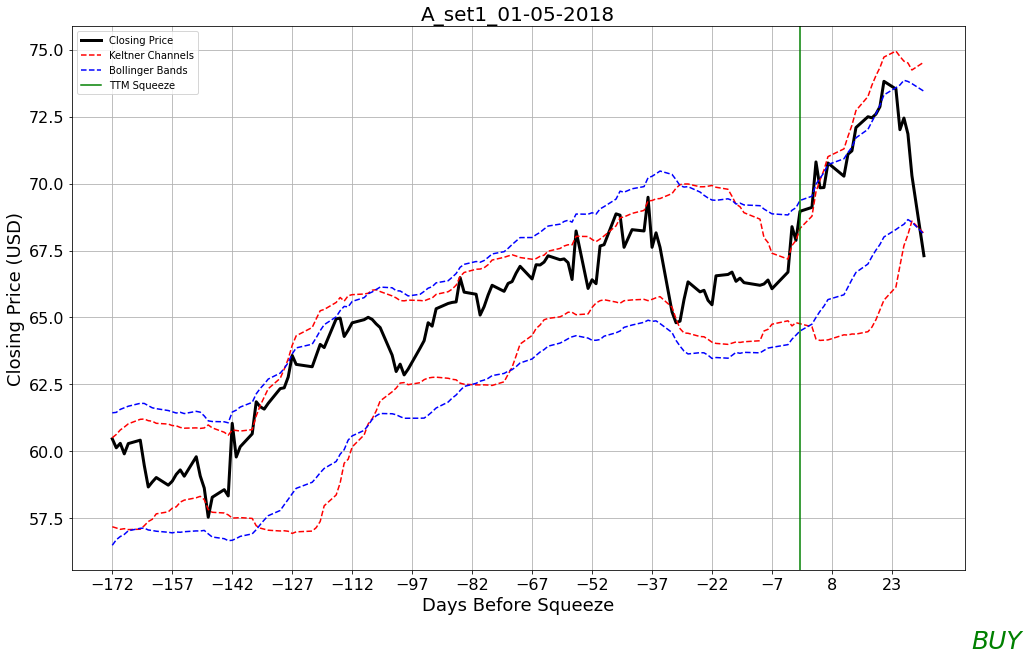

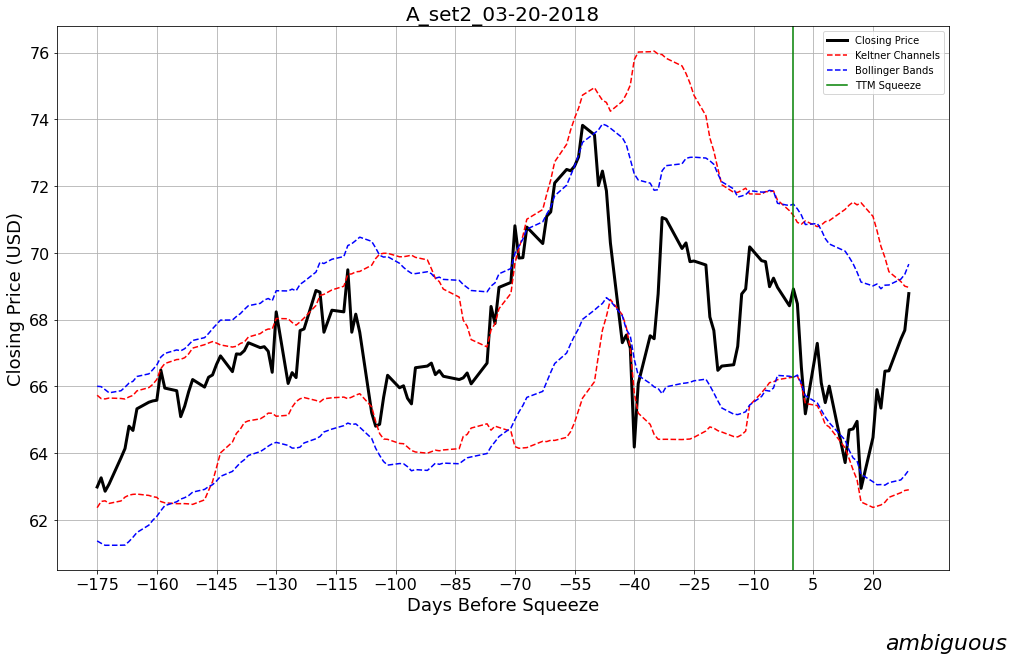

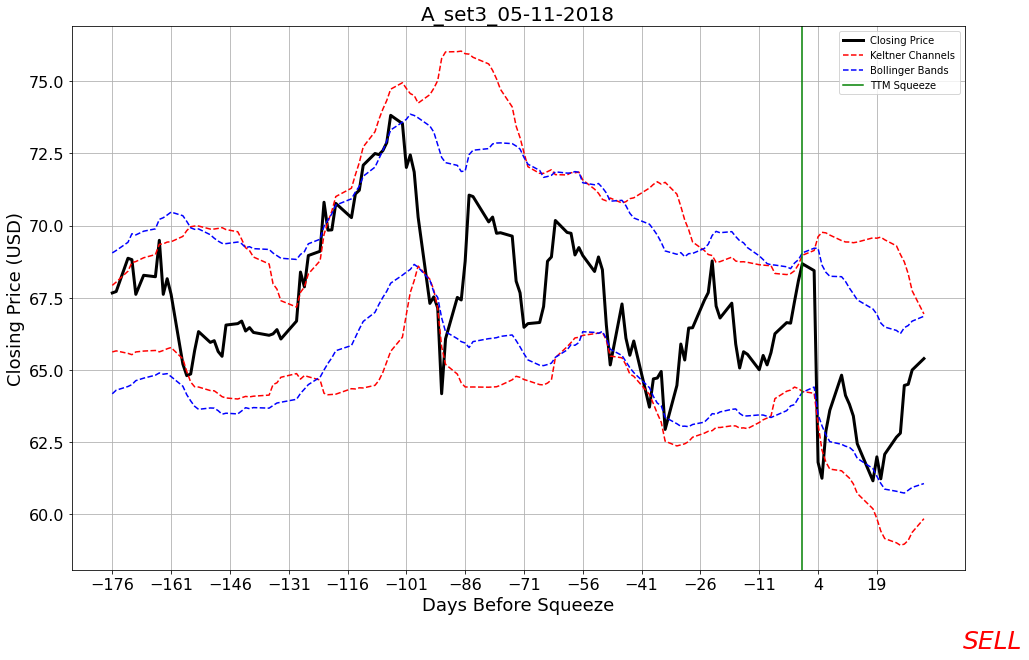

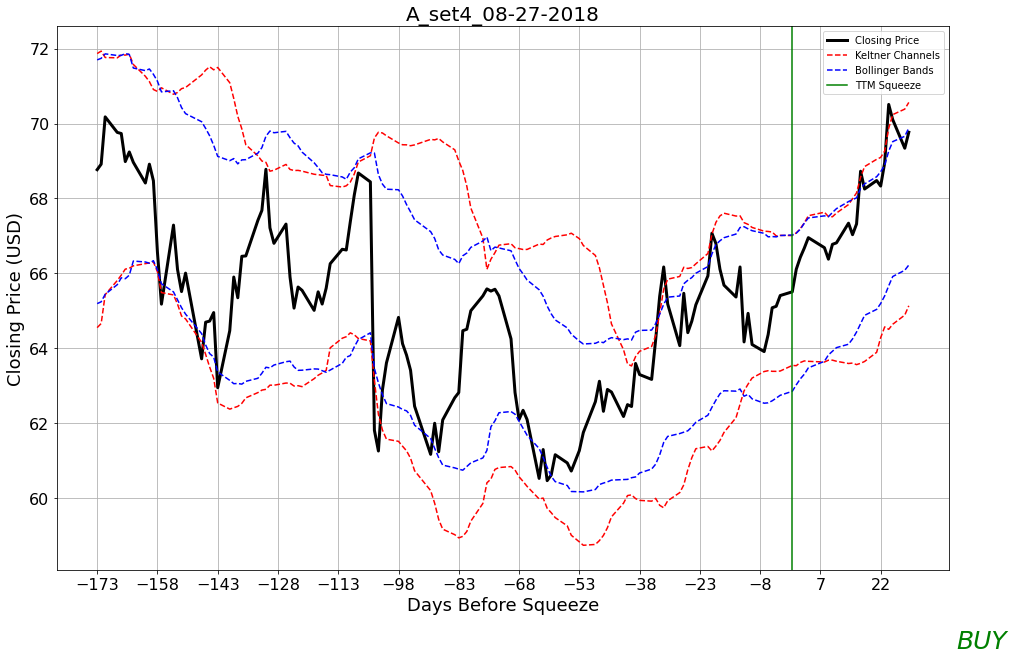

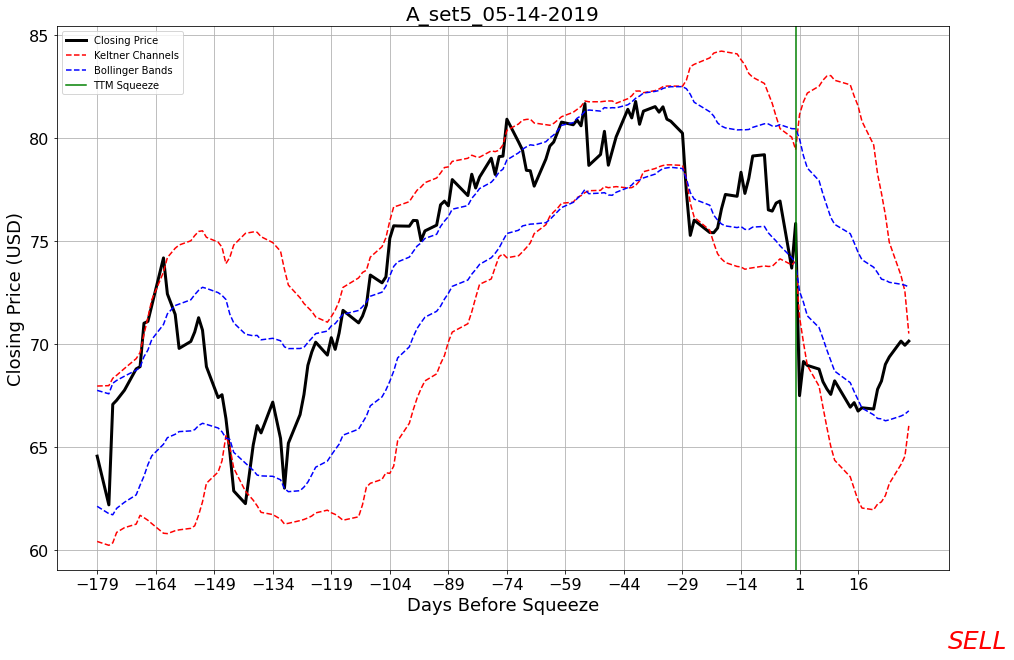

In [142]:
features = dict()

count = 0
for str_stock in ticker_target:
    count+= 1 
    stock = data[str_stock][-2200:] #Take only 2000 most recents trading days (around 2010)
    stock.drop(columns = ["close"], inplace=True)
    stock.rename(columns = {"adjClose":"close"}, inplace=True) #Use adjusted close price instead of closing price
    stock_ttm_df,target_dates = get_ttm_dates(stock)
    
    
    
    if(len(target_dates) == 0):#the list is empty
        continue
        
    ttm_sets = separate_dates(target_dates)
    
    features[str_stock] = dict()

    for date_set in ttm_sets.keys():
        set_up_day = max(ttm_sets[date_set]) #Get the last day of the set - set_up_day
        ind = stock_ttm_df.index.get_loc(set_up_day)
        
        stock_target_df = stock_ttm_df.iloc[ind-120:ind+21] #last day of the set minus 120 days and plus 21 days

        #Get the amount of days relative to the set_up_day and make it the index
        stock_target_df = days_difference(stock_target_df,set_up_day)
        

        #label each set for machine learning
        
        label = get_label(stock_target_df)
        
        set_up_day_str = set_up_day.strftime("%m-%d-%Y")
        name = str_stock+"_"+date_set+"_"+set_up_day_str

        #print(name)
        features[str_stock][name] = dict()
        features[str_stock][name]["label"] = label
        features[str_stock][name]["data"] = stock_target_df
        #features[str_stock]["name"] = name

        save_figure(stock_target_df, name,label)
    print(str(count)+"/"+str(len(ticker_target)))
    break
    

In [134]:
pickle_out = open("all_features.pickle","wb")
pickle.dump(features, pickle_out)
pickle_out.close()